In [4]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


In [5]:
from google.colab import drive
   

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
data_dir ="/content/gdrive/MyDrive/dataset/photos"
   

In [8]:
import pathlib                        #We have used pathlib in data directory so that we are able to use glob and you can 
data_dir = pathlib.Path(data_dir)      #already see the advantages of glob, when we use pathlib we see tha it is a Windows path 
data_dir                             #We converted our directory to windows pathlib directory

PosixPath('/content/gdrive/MyDrive/dataset/photos')

In [9]:
alzheimer_images_dict = {                                    #here we have created a dictionary, if we do 
    'mild': list(data_dir.glob('MildDemented/*')),           #alzheimer_images_dict[MildDemented] we get all paths of 
    'moderate': list(data_dir.glob('ModerateDemented/*')),   #milddemented
    'no': list(data_dir.glob('NonDemented/*')),
    'verymild': list(data_dir.glob('VeryMildDemented/*')),
  
}

In [10]:
alzheimer_labels_dict = {   #here I am assigning labels to each of the  classes
    'mild': 0,
    'moderate': 1,
    'no': 2,
    'verymild': 3,
    
}

In [11]:
X, y = [], []

for alzheimer_name, images in alzheimer_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(alzheimer_labels_dict[alzheimer_name])
print(X[0].shape)  

(224, 224, 3)


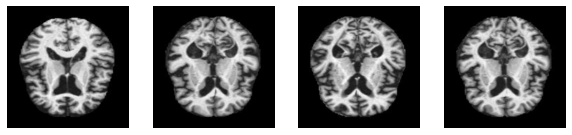

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [14]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [15]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (4288, 224, 224, 3)
X_test Shape:  (2112, 224, 224, 3)
y_train Shape:  (4288, 4)
y_test Shape:  (2112, 4)


In [16]:
 from keras.applications.densenet import DenseNet121



img_rows, img_cols = 224, 224 


pretained_model =tf.keras.applications.DenseNet121(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))  #where ever false is there means that they are not going  to trained 
                                                        #again as they are alredy being trained
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in pretained_model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(pretained_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

29097984/29084464 [==============================] - 1s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 BatchNormalization False
8 Activation False
9 Conv2D False
10 BatchNormalization False
11 Activation False
12 Conv2D False
13 Concatenate False
14 BatchNormalization False
15 Activation False
16 Conv2D False
17 BatchNormalization False
18 Activation False
19 Conv2D False
20 Concatenate False
21 BatchNormalization False
22 Activation False
23 Conv2D False
24 BatchNormalization False
25 Activation False
26 Conv2D False
27 Concatenate False
28 BatchNormalization False
29 Activation False
30 Conv2D False
31 BatchNormalization False
32 Activation False
33 Conv2D False
34 Concatenate False
35 BatchNormalization False
36 Activation False
37 Conv2D False
38 BatchNormalization False
39 Activation False
40 Conv2D False
41 Concatenate False
42 BatchNormalization False
43 Activation False


In [17]:
num_classes = 4
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""                      #here I adding extra additional layers that will be helpful 
                                                              #in my program.
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(pretained_model, num_classes)   #here you can see I am passing vgg and number of classes to the lw func and lw bottom model
                                 #will be vgg
model = Model(inputs = pretained_model.input, outputs = FC_Head)


In [19]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [20]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [21]:
history = model.fit(X_train,y_train,
                    epochs=100, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/100
134/134 [==============================] - 36s 144ms/step - loss: 1.1924 - accuracy: 0.5490 - val_loss: 0.9816 - val_accuracy: 0.5445
Epoch 2/100
134/134 [==============================] - 18s 131ms/step - loss: 0.8909 - accuracy: 0.5779 - val_loss: 0.9135 - val_accuracy: 0.5701
Epoch 3/100
134/134 [==============================] - 18s 133ms/step - loss: 0.8668 - accuracy: 0.5870 - val_loss: 0.8546 - val_accuracy: 0.5786
Epoch 4/100
134/134 [==============================] - 18s 136ms/step - loss: 0.8417 - accuracy: 0.6017 - val_loss: 0.8778 - val_accuracy: 0.5900
Epoch 5/100
134/134 [==============================] - 19s 139ms/step - loss: 0.8306 - accuracy: 0.6056 - val_loss: 0.8915 - val_accuracy: 0.5492
Epoch 6/100
134/134 [==============================] - 19s 144ms/step - loss: 0.8224 - accuracy: 0.6126 - val_loss: 0.9596 - val_accuracy: 0.5421
Epoch 7/100
134/134 [==============================] - 20s 150ms/step - loss: 0.7912 - accuracy: 0.6269 - val_loss: 0.8012 -

In [22]:
model.save('densenetalzheimer2')

INFO:tensorflow:Assets written to: densenetalzheimer2/assets


In [23]:
from keras.models import load_model

In [24]:
new_model=load_model('densenetalzheimer2')

In [25]:
new_model.evaluate(X_test,y_test)

66/66 [==============================] - 8s 91ms/step - loss: 0.5171 - accuracy: 0.8688


[0.5170690417289734, 0.8688446879386902]

In [26]:
predictions = new_model.predict(X_test) #we get this array as we have used linear activation func at last
predictions

array([[3.8449674e-10, 4.8018363e-09, 9.9822861e-01, 1.7714184e-03],
       [2.0740709e-11, 8.1979359e-14, 9.9998856e-01, 1.1503228e-05],
       [5.3688684e-05, 6.0813868e-11, 4.4438953e-04, 9.9950182e-01],
       ...,
       [9.9999917e-01, 1.2677653e-12, 3.0263791e-07, 5.3109187e-07],
       [8.1200011e-07, 5.3822100e-13, 9.9999261e-01, 6.5568379e-06],
       [1.7862415e-09, 1.1977467e-13, 9.9655944e-01, 3.4404946e-03]],
      dtype=float32)

In [27]:
score = tf.nn.softmax(predictions[0]) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.17497066, 0.17497066, 0.47477782, 0.17528087], dtype=float32)>

In [28]:
np.argmax(score)

2

In [29]:
score = tf.nn.softmax(predictions) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(2112, 4), dtype=float32, numpy=
array([[0.17497066, 0.17497066, 0.47477782, 0.17528087],
       [0.17487831, 0.17487831, 0.4753631 , 0.17488033],
       [0.17491327, 0.17490388, 0.17498162, 0.4752012 ],
       ...,
       [0.4753666 , 0.17487776, 0.17487781, 0.17487784],
       [0.17487825, 0.1748781 , 0.47536445, 0.17487927],
       [0.175058  , 0.175058  , 0.4742226 , 0.17566134]], dtype=float32)>

In [30]:
new=[]
ind=[]
for i in range(0,len(score)):
    maximum=-1
    for j in range(0,len(score[i])):
        
        if score[i][j]>maximum:
            maximum=score[i][j]
            index=j
            
    ind.append(index)       
    
    

print(ind)

[2, 2, 3, 3, 0, 2, 3, 2, 2, 2, 2, 0, 2, 3, 0, 3, 2, 2, 3, 0, 2, 0, 2, 2, 3, 0, 2, 2, 1, 2, 2, 3, 3, 3, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 3, 3, 2, 3, 3, 3, 2, 2, 0, 1, 0, 2, 2, 3, 1, 0, 3, 2, 0, 0, 3, 3, 2, 3, 2, 0, 3, 2, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 0, 2, 3, 2, 3, 3, 3, 0, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 0, 3, 2, 3, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 0, 0, 3, 2, 2, 2, 3, 3, 0, 2, 2, 2, 2, 3, 3, 3, 0, 0, 2, 3, 0, 2, 3, 2, 3, 2, 2, 0, 0, 2, 3, 2, 3, 2, 2, 2, 0, 0, 0, 2, 3, 0, 2, 3, 2, 3, 3, 0, 0, 2, 3, 2, 3, 3, 3, 0, 3, 2, 2, 3, 2, 2, 0, 0, 2, 2, 2, 3, 2, 0, 3, 0, 3, 0, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 3, 2, 3, 2, 2, 0, 0, 3, 2, 2, 3, 2, 3, 0, 0, 3, 3, 2, 0, 2, 2, 2, 3, 0, 2, 2, 3, 2, 3, 2, 0, 0, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 0, 0, 

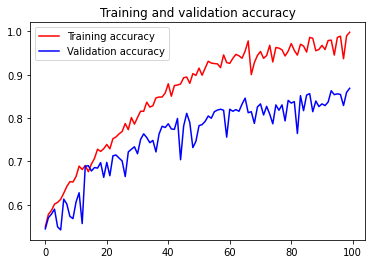

<Figure size 432x288 with 0 Axes>

In [31]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [32]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [33]:
y_test_labels=[np.argmax(i) for i in y_test]
y_test_labels[:5]

[2, 2, 3, 3, 0]

In [34]:
X_test_labels=[np.argmax(i) for i in X_test]
X_test_labels[:5]

[56163, 72336, 60129, 64959, 111201]

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from pylab import rcParams

In [38]:
class_labels=["mild","moderate","no","verymild"]
  

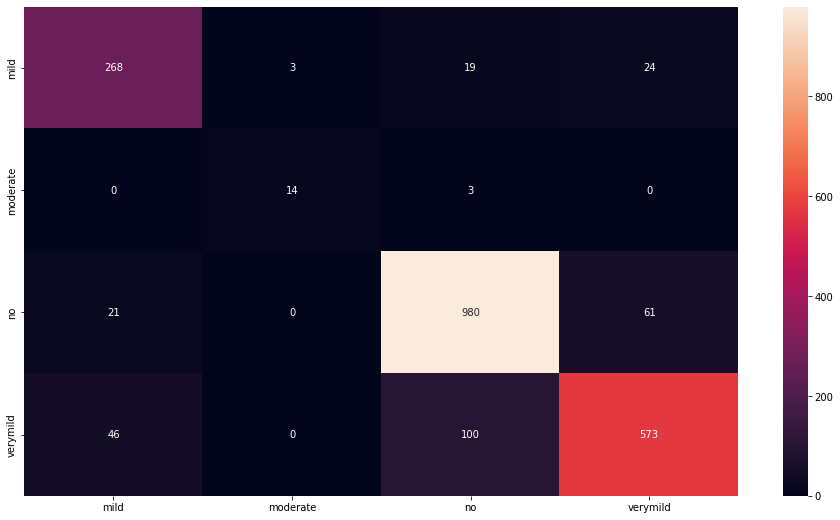

In [39]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,9))
cm=confusion_matrix(y_test_labels,ind)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)

In [40]:
from sklearn.metrics import classification_report
cr=classification_report(y_test_labels,ind,target_names=class_labels)
print (cr)

              precision    recall  f1-score   support

        mild       0.80      0.85      0.83       314
    moderate       0.82      0.82      0.82        17
          no       0.89      0.92      0.91      1062
    verymild       0.87      0.80      0.83       719

    accuracy                           0.87      2112
   macro avg       0.85      0.85      0.85      2112
weighted avg       0.87      0.87      0.87      2112

